# **シンプルなブレンディングを試してみる**

### **必要な関数・ライブラリ**

In [57]:
# データ加工・処理・分析モジュール
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import os
import random

%matplotlib inline

import time

In [58]:
def set_time(dataframe, col_name):
    '''
    to_datetimeを使うための前処理
    '''
    dataframe[col_name] = dataframe[col_name].map(lambda x : transform_time(x))
    return dataframe

In [138]:
def add_time_sincos(input_data, key="datetime"):
    '''
    時間や月のデータを加える
    '''
    input_data['hour'] = input_data['datetime'].map(lambda x: int(x.hour))
    input_data['minute'] = input_data['datetime'].map(lambda x: int(x.minute))
    input_data['month'] = input_data['datetime'].map(lambda x: int(x.month))
    input_data['month_cos'] = input_data['month'].map(lambda x: np.cos(np.pi * x / 12))
    input_data['month_sin'] = input_data['month'].map(lambda x: np.sin(np.pi * x / 12))
    input_data['hour_cos'] = input_data['hour'].map(lambda x: np.cos(np.pi * x / 24))
    input_data['hour_sin'] = input_data['hour'].map(lambda x: np.sin(np.pi * x / 24))
    input_data['min_cos'] = input_data['minute'].map(lambda x: np.cos(np.pi * x / 60))
    input_data['min_sin'] = input_data['minute'].map(lambda x: np.sin(np.pi * x / 60))
    input_data = input_data.drop(['hour', 'month', 'minute'], axis=1)
    return input_data

In [59]:
def transform_time(x):
    '''
    set_time内で使う関数
    to_datetimeで24時をサポートしないので00に変更する処理
    '''
    str_x = str(x)
    res = ''
    if str(x)[8:10] == '24':
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' 00:'+str_x[10:12] 
    else:
        res = str_x[0:4] + '-' + str_x[4:6] + '-' + str_x[6:8] + ' '+ str_x[8:10] +':'+str_x[10:12]
    return res

In [60]:
def drop_nan(X, Y):
    '''
    正解データがnanであるデータの組を削除
    '''
    mask = np.isnan(Y)
    X = X[~mask]
    Y = Y[~mask]
    return X, Y

In [148]:
n_estimators = 20
max_depth = 5
max_features = "sqrt"

In [99]:
# 発電量データ
all_output_30 = pd.read_csv('data/processed_data/out_put.tsv', delimiter = '\t')
all_output_30['datetime'] = all_output_30['datetime'].map(lambda x : pd.to_datetime(x))

### **浮島発電所について**

In [189]:
target_place = 1

In [190]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]

In [191]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [192]:
# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [193]:
# 月, 時間の情報を加える
train_prediction = add_time_sincos(train_prediction)
test_prediction = add_time_sincos(test_prediction)

In [194]:
test_prediction.columns

Index(['datetime', 'targetplace_1_kwh_fc_one_layer_2000',
       'targetplace_1_kwh_fc_one_layer_3000',
       'targetplace_1_kwh_fc_one_layer_4000',
       'targetplace_1_kwh_fc_one_layer_5000',
       'targetplace_1_kwh_fc_month_one_layer_1000',
       'targetplace_1_kwh_fc_month_one_layer_2000',
       'targetplace_1_kwh_fc_month_one_layer_3000',
       'targetplace_1_kwh_fc_month_one_layer_4000',
       'targetplace_1_kwh_fc_month_one_layer_5000', 'month_cos', 'month_sin',
       'hour_cos', 'hour_sin', 'min_cos', 'min_sin'],
      dtype='object')

In [195]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [196]:
X, Y = drop_nan(X, Y)

In [197]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

In [208]:
# ランダムフォレストリグレッサー
rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, max_features=max_features)
rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = 9, max_features=max_features)

rf.fit(X_train, Y_train)
Y_train_pred = rf.predict(X_train)
Y_val_pred = rf.predict(X_val)
print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

train_mae :  96.3501931924
val_mae :  104.196278047


In [210]:
train_maes = []
val_maes = []
for i in range(15):
    rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = i+1, max_features=max_features)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

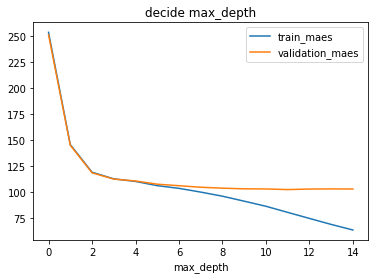

In [213]:
plt.plot(train_maes, label="train_maes")
plt.plot(val_maes, label="validation_maes")
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

In [161]:
Y_test_pred = rf.predict(X_test)

In [162]:
s_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2016/01/01 00:00')].index[0]
e_idx = test_prediction[test_prediction['datetime'] == pd.to_datetime('2017/3/31 23:30')].index[0]
predict_data = pd.DataFrame({"datetime":test_prediction['datetime'][s_idx:e_idx+1]})
predict_data.index = np.arange(len(predict_data))

In [163]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = Y_test_pred

### **扇島発電所について**

In [214]:
target_place = 2

In [215]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]

In [216]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [217]:
# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [218]:
# 月, 時間の情報を加える
train_prediction = add_time_sincos(train_prediction)
test_prediction = add_time_sincos(test_prediction)

In [219]:
test_prediction.columns

Index(['datetime', 'targetplace_2_kwh_fc_one_layer_2000',
       'targetplace_2_kwh_fc_one_layer_3000',
       'targetplace_2_kwh_fc_one_layer_4000',
       'targetplace_2_kwh_fc_one_layer_5000',
       'targetplace_2_kwh_fc_month_one_layer_1000',
       'targetplace_2_kwh_fc_month_one_layer_2000',
       'targetplace_2_kwh_fc_month_one_layer_3000',
       'targetplace_2_kwh_fc_month_one_layer_4000',
       'targetplace_2_kwh_fc_month_one_layer_5000', 'month_cos', 'month_sin',
       'hour_cos', 'hour_sin', 'min_cos', 'min_sin'],
      dtype='object')

In [221]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [222]:
X, Y = drop_nan(X, Y)

In [223]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

In [225]:
train_maes = []
val_maes = []
for i in range(15):
    rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = i+1, max_features=max_features)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

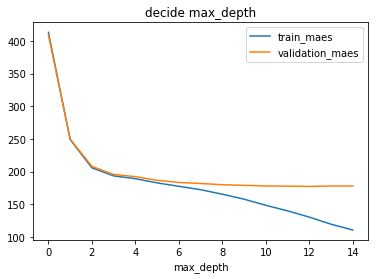

In [226]:
plt.plot(train_maes, label="train_maes")
plt.plot(val_maes, label="validation_maes")
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

In [224]:
# ランダムフォレストリグレッサー
rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, max_features=max_features)
rf.fit(X_train, Y_train)
Y_train_pred = rf.predict(X_train)
Y_val_pred = rf.predict(X_val)
print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

train_mae :  187.547110739
val_mae :  190.547115887


In [174]:
Y_test_pred = rf.predict(X_test)

In [175]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = Y_test_pred

### **米倉山発電所について**

In [227]:
target_place = 3

In [228]:
# 発電量データ
output_30 = all_output_30[['datetime', 'SOLA0'+str(target_place)]]

In [229]:
# いろんなモデルの予測値の集合(学習用)
train_prediction = pd.read_csv("data/predicted_data/predict_train_SOLA0"+str(target_place)+".tsv", delimiter="\t")
train_prediction['datetime'] = train_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [230]:
# いろんなモデルの予測値の集合(ほんちゃん)
test_prediction = pd.read_csv("data/predicted_data/predict_SOLA0"+str(target_place)+".tsv", delimiter="\t")
test_prediction['datetime'] = test_prediction['datetime'].map(lambda x : pd.to_datetime(x))

In [231]:
# 月, 時間の情報を加える
train_prediction = add_time_sincos(train_prediction)
test_prediction = add_time_sincos(test_prediction)

In [232]:
train_prediction.columns

Index(['datetime', 'targetplace_3_kwh_fc_one_layer_2000',
       'targetplace_3_kwh_fc_one_layer_3000',
       'targetplace_3_kwh_fc_one_layer_4000',
       'targetplace_3_kwh_fc_one_layer_5000',
       'targetplace_3_kwh_fc_month_one_layer_1000',
       'targetplace_3_kwh_fc_month_one_layer_2000',
       'targetplace_3_kwh_fc_month_one_layer_3000',
       'targetplace_3_kwh_fc_month_one_layer_4000',
       'targetplace_3_kwh_fc_month_one_layer_5000', 'month_cos', 'month_sin',
       'hour_cos', 'hour_sin', 'min_cos', 'min_sin'],
      dtype='object')

In [233]:
t_s_datetime = train_prediction['datetime'][0]
t_e_datetime = train_prediction['datetime'][len(train_prediction)-1]
train_y_s_idx = output_30[output_30['datetime'] == t_s_datetime].index[0]
train_y_e_idx = output_30[output_30['datetime'] == t_e_datetime].index[0]

X = np.array(train_prediction.drop(["datetime"], axis=1))
Y = output_30["SOLA0"+str(target_place)][train_y_s_idx:train_y_e_idx+1]
X_test = np.array(test_prediction.drop(["datetime"], axis=1))

In [234]:
X, Y = drop_nan(X, Y)

In [235]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=int((X.shape[0] * 0.3)))

In [236]:
train_maes = []
val_maes = []
for i in range(15):
    rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = i+1, max_features=max_features)
    rf.fit(X_train, Y_train)
    Y_train_pred = rf.predict(X_train)
    Y_val_pred = rf.predict(X_val)
    train_maes.append(np.abs(Y_train_pred - Y_train).mean())
    val_maes.append(np.abs(Y_val_pred - Y_val).mean())
#     print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
#     print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

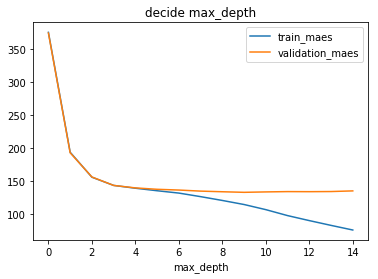

In [238]:
plt.plot(train_maes, label="train_maes")
plt.plot(val_maes, label="validation_maes")
plt.xlabel("max_depth")
plt.title("decide max_depth")
plt.legend()

In [237]:
# ランダムフォレストリグレッサー
rf = RandomForestRegressor(n_estimators = n_estimators, max_depth = max_depth, max_features=max_features)
rf.fit(X_train, Y_train)
Y_train_pred = rf.predict(X_train)
Y_val_pred = rf.predict(X_val)
print("train_mae : ", np.abs(Y_train_pred - Y_train).mean())
print("val_mae : ", np.abs(Y_val_pred - Y_val).mean())

train_mae :  140.334195018
val_mae :  141.11264297


In [186]:
Y_test_pred = rf.predict(X_test)

In [187]:
# 2016/01/01 00:00 ~ 2017/3/31 23:50の予測データを書き出す
predict_data["blending_"+str(target_place)] = Y_test_pred

### **書き出す**

In [188]:
predict_data.to_csv('data/predicted_data/simple_blending_prediction.tsv', sep = '\t', index=False)